In [8]:
import overcooked

In [9]:
overcooked_env = overcooked.Overcooked("CrampedRoom")

In [3]:
observation, episode_return, episode_length = overcooked_env.reset(), 0, 0
observation = overcooked_env.mdp.lossless_state_encoding(observation, debug=False)[0]

In [10]:
NORTH = (0, -1)
SOUTH = (0, 1)
EAST = (1, 0)
WEST = (-1, 0)
ALL_DIRECTIONS = INDEX_TO_DIRECTION = [NORTH, SOUTH, EAST, WEST]
DIRECTION_TO_INDEX = {a: i for i, a in enumerate(INDEX_TO_DIRECTION)}
OPPOSITE_DIRECTIONS = {NORTH: SOUTH, SOUTH: NORTH, EAST: WEST, WEST: EAST}
DIRECTION_TO_NAME = {
    d: name
    for d, name in zip(
        [NORTH, SOUTH, EAST, WEST], ["NORTH", "SOUTH", "EAST", "WEST"]
    )
}

In [11]:
import copy
import itertools

class Direction(object):
    """
    The four possible directions a player can be facing.
    """

    NORTH = (0, -1)
    SOUTH = (0, 1)
    EAST = (1, 0)
    WEST = (-1, 0)
    ALL_DIRECTIONS = INDEX_TO_DIRECTION = [NORTH, SOUTH, EAST, WEST]
    DIRECTION_TO_INDEX = {a: i for i, a in enumerate(INDEX_TO_DIRECTION)}
    OPPOSITE_DIRECTIONS = {NORTH: SOUTH, SOUTH: NORTH, EAST: WEST, WEST: EAST}
    DIRECTION_TO_NAME = {
        d: name
        for d, name in zip(
            [NORTH, SOUTH, EAST, WEST], ["NORTH", "SOUTH", "EAST", "WEST"]
        )
    }

    @staticmethod
    def get_adjacent_directions(direction):
        """Returns the directions within 90 degrees of the given direction.

        direction: One of the Directions, except not Direction.STAY.
        """
        if direction in [Direction.NORTH, Direction.SOUTH]:
            return [Direction.EAST, Direction.WEST]
        elif direction in [Direction.EAST, Direction.WEST]:
            return [Direction.NORTH, Direction.SOUTH]
        raise ValueError("Invalid direction: %s" % direction)


class Action(object):
    """
    The six actions available in the OvercookedGridworld.

    Includes definitions of the actions as well as utility functions for
    manipulating them or applying them.
    """

    STAY = (0, 0)
    INTERACT = "interact"
    ALL_ACTIONS = INDEX_TO_ACTION = Direction.INDEX_TO_DIRECTION + [
        STAY,
        INTERACT,
    ]
    INDEX_TO_ACTION_INDEX_PAIRS = [
        v for v in itertools.product(range(len(INDEX_TO_ACTION)), repeat=2)
    ]
    ACTION_TO_INDEX = {a: i for i, a in enumerate(INDEX_TO_ACTION)}
    MOTION_ACTIONS = Direction.ALL_DIRECTIONS + [STAY]
    ACTION_TO_CHAR = {
        Direction.NORTH: "↑",
        Direction.SOUTH: "↓",
        Direction.EAST: "→",
        Direction.WEST: "←",
        STAY: "stay",
        INTERACT: INTERACT,
    }
    NUM_ACTIONS = len(ALL_ACTIONS)

    @staticmethod
    def to_char(action):
        assert action in Action.ALL_ACTIONS
        return Action.ACTION_TO_CHAR[action]

    @staticmethod
    def joint_action_to_char(joint_action):
        assert all([a in Action.ALL_ACTIONS for a in joint_action])
        return tuple(Action.to_char(a) for a in joint_action)


In [12]:
action_list = [Action.INTERACT,Action.STAY,Action.INDEX_TO_ACTION[0],Action.INDEX_TO_ACTION[1],Action.INDEX_TO_ACTION[2],Action.INDEX_TO_ACTION[3]]
action_text = ["interacted", "done nothing", "moved up", "moved down", "moved right", "moved left"]

In [6]:
import anthropic
import os

os.environ["ANTHROPIC_API_KEY"] = ''

client = anthropic.Anthropic()

In [8]:
token_count = client.count_tokens("The scene is described by grid: Grid = [['X', 'X', 'P', 'X', 'X'], ['O', ' ', ' ', ' ', 'O'], ['X', ' ', ' ', ' ', 'X'], ['X', 'D', 'X', 'S', 'X']]. \
Where X represents countertop, \
P represents a pot, O represents an onion, D represents plates and S represents serving counter. ' ' represents an empty space. All of the items are on a countertop. \
The scene is 4 rows tall and 5 columns wide. \
Top row: Countertop on the left and right sides, a pot in the center. Second row: Onions on both ends , empty space in the middle three positions. Third row: \
Countertop on both ends, empty space in the middle three positions. Bottom row:	Countertop on the left, right, and in the center, plates on the left side of the center, \
serving counter on the right side of the center \
You are chef. Your aim is to serve cooked soup to the serving counter. \
To cook a soup, you first need to put 3 onions inside the pot, \
wait for it to cook for 20 time steps, serve it on a plate and deliver it to the serving counter. You can only do one action at a time. Each movement corresponds to moving a square left, right, top or down. \
You have a partner with the same goal as you. \
Your position is describe by a grid. For example: Grid = [[0, 0, 0, 0], \
[0, 0, 1, 0], \
[0, 0, 0, 0], \
[0, 0, 0, 0], \
[0, 0, 0, 0]]. \
Where '1' represents your current location. \
Output your final answer after your reasoning after the tag <action> with only the following options: Move left, Move right, Move up, Move down, Interact, Do nothing.")
print(token_count)

403


In [13]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import torch

In [14]:
model_name_or_path = "mattshumer/Reflection-Llama-3.1-70B"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/59.6k [00:00<?, ?B/s]

model-00001-of-00162.safetensors:   0%|          | 0.00/4.20G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [20]:
from tqdm import trange, tqdm
import concurrent.futures
import time

def process_item(m):
    message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        # model="claude-3-haiku-20240307",
        max_tokens=1000,
        temperature=0,
        system = "You are a world-class AI system, capable of complex reasoning and reflection. Reason through the query inside \
<thinking> tags, and then provide your final response inside <output> tags. If you detect that you made a mistake in your reasoning \
at any point, correct yourself inside <reflection> tags.\n\n\
The scene is 4 rows tall and 5 columns wide.\nTop row:\n\nCountertop on all sides\nA pot in the center on the countertop\n\nSecond row:\n\nOnions on both \
ends on the countertop.\nEmpty space in the middle three positions\n\nThird row:\n\nCountertop on both ends\nEmpty space in the middle three positions\n\nBottom row:\n\nCountertop on all sides, \
\nPlates on the left side of the center\nServing counter on the right side of the center\n\nYour aim is to serve cooked soup to the serving counter. \
To cook a soup, you first need to put 3 onions inside the pot, wait for it to cook for 20 time steps, serve it on a plate and deliver it to the serving counter. \
Assuming you can only do one action at a time.\n\nYou have a partner who has the same goal as you.\n\nOutput your final answer with a tag <action> after your reasoning with \
only the following options: Move left, Move right, Move up, Move down, Interact, Do nothing \
Before doing your reasoning, do a self-reflection on your previous action. \
You have to be right beside the item and facing the item to interact with them. Moving in a direction will force your character to face the same direction. \
Always refer to the scene to make sure where you are facing and what is directly in front of you. \
Interacting with an onion in front of you picks it up and hold it in your hands; Interacting with a pot while holding an onion put it into the pot. \
Only one person can stand within a square, and by moving right or left, moves you to the right or left of the map. You cannot move into a square which is a countertop. \
In the image:\nThere's a pot (the dark rectangle at the top)\nThere are several onions scattered around (the light yellow objects)\nThere's a serving counter (the gray area)\n\
The dark brown areas are where the countertop is, which cannot be moved into; You can only move within the empty spaces in the middle three positions on second row and the middle three \
positions on the third row.",
        messages=m
    )
    return message.content

def parallel_process_with_process_pool(messages, num_workers=2):
    results = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        # future_to_item = {executor.submit(process_item, m): m for m in messages}
        res = executor.map(process_item, (m for m in messages))

        for r in res:
            results.append(r)
    #     for future in tqdm(concurrent.futures.as_completed(future_to_item), total=len(future_to_item), desc="Processing items"):
    #     # for future in concurrent.futures.as_completed(future_to_item):
    #         item = future_to_item[future]
    #         try:
    #             result = future.result()
    #             if result is not None:
    #                 results.append(result)
    #         except Exception as e:
    #             # pass
    #             print(f'Item {item} generated an exception: {e}')
    return results


In [8]:
import overcooked
import numpy as np
import os

In [9]:
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer

In [14]:
observation, episode_return, episode_length = overcooked_env.reset(), 0, 0
observation

In [10]:
GRID= [['X', 'X', 'P', 'X', 'X'], ['O', ' ', ' ', ' ', 'O'], ['X', ' ', ' ', ' ', 'X'], ['X', 'D', 'X', 'S', 'X']]

In [11]:
row_text = ["top row", "second row", "third row", "bottom row"]
col_text = ["left end", "left side of the center", "middle", "right side of the center", "right end",]

In [18]:
def process_messages(messages, obs, facing_dir, action):
    action_text_list = ["moved up", "moved down", "moved right", "moved left", "done nothing", "interacted with the item in front",]
    row, col = np.unravel_index(np.argmax(obs[...,0].transpose(), axis=None), obs[...,0].transpose().shape)
    agent_0 = "on the {} of the {}".format(col_text[col], row_text[row])
    row, col = np.unravel_index(np.argmax(obs[...,1].transpose(), axis=None), obs[...,1].transpose().shape)
    agent_1 = "on the {} of the {}".format(col_text[col], row_text[row])

    for agent in range(2):
        if agent == 0:
            if action is None:
                prompt = "You are the chef in blue hat. You are {}, facing {}. Your partner is {}, facing {}.".format(agent_0, facing_dir[0], agent_1, facing_dir[1])
            else:           
                prompt = "You are the chef in blue hat. You have tried to {} and now you are {}, facing {}. Your partner have {} and now your partner is {}, facing {}.".format(action_text_list[Action.ACTION_TO_INDEX[action[0]]], agent_0, facing_dir[0], action_text_list[Action.ACTION_TO_INDEX[action[1]]], agent_1, facing_dir[1])       
        if agent == 1:
            if action is None:
                prompt = "You are the chef in green hat. You are {}, facing {}. Your partner is {}, facing {}.".format(agent_1, facing_dir[1], agent_0, facing_dir[0])
            else:           
                prompt = "You are the chef in green hat You have tried to {} and now you are {}, facing {}. Your partner have {} and now your partner is {}, facing {}.".format(action_text_list[Action.ACTION_TO_INDEX[action[1]]], agent_1, facing_dir[1], action_text_list[Action.ACTION_TO_INDEX[action[0]]], agent_0, facing_dir[0])   
        message={
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    ]
                }

        messages[agent].append(message)

    return messages

def get_action(messages, obs, facing_dir, action, image_data):   
    # action_text = ["moved up", "moved down", "moved right", "moved left", "done nothing","interacted with the item in front"]
    action_text_list = ["moved up", "moved down", "moved right", "moved left", "done nothing", "interacted with the item in front",]
    row, col = np.unravel_index(np.argmax(obs[...,0].transpose(), axis=None), obs[...,0].transpose().shape)
    agent_0 = "on the {} of the {}".format(col_text[col], row_text[row])
    row, col = np.unravel_index(np.argmax(obs[...,1].transpose(), axis=None), obs[...,1].transpose().shape)
    agent_1 = "on the {} of the {}".format(col_text[col], row_text[row])

    for agent in range(2):
        if agent == 0:
            if action is None:
                prompt = "You are {}, facing {}. Your partner is {}, facing {}. The image shows the current scene.".format(agent_0, facing_dir[0], agent_1, facing_dir[1])
            else:           
                prompt = "You have tried to {} and now you are {}, facing {}. Your partner have tried to {} and now your partner is {}, facing {}. The image shows the current scene.".format(action_text_list[Action.ACTION_TO_INDEX[action[0]]], agent_0, facing_dir[0], action_text_list[Action.ACTION_TO_INDEX[action[1]]], agent_1, facing_dir[1])       
        if agent == 1:
            if action is None:
                prompt = "You are {}, facing {}. Your partner is {}, facing {}. The image shows the current scene.".format(agent_1, facing_dir[1], agent_0, facing_dir[0])
            else:           
                prompt = "You have tried to {} and now you are {}, facing {}. Your partner have tried to {} and now your partner is {}, facing {}. The image shows the current scene.".format(action_text_list[Action.ACTION_TO_INDEX[action[1]]], agent_1, facing_dir[1], action_text_list[Action.ACTION_TO_INDEX[action[0]]], agent_0, facing_dir[0])   
        message={
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": 'image/jpeg',
                            "data": image_data,
                        },
                    },
                    ]
                }

        messages[agent].append(message)
    
    done=False
    while not done:
        try:
            answers = parallel_process_with_process_pool(messages, num_workers=2)
            done=True
        except Exception as e:
            print(e)
            time.sleep(60)
        # answers = parallel_process_with_process_pool(messages, num_workers=2)
        
    action = [0,0]
    for agent in range(2):
        reply = answers[agent][0].text
        action_text = reply.split("<action>")[-1].split("</action>")[0]
        if action_text == "Move left":
            action[agent] = action_list[5]
        elif action_text == "Move right":
            action[agent] = action_list[4]
        elif action_text == "Move up":
            action[agent] = action_list[2]
        elif action_text == "Move down":
            action[agent] = action_list[3]
        elif action_text == "Interact":
            action[agent] = action_list[0]
        else:
            action[agent] = action_list[1]
    
    return answers, action, messages

In [19]:
direction_text=["up","down","right","left"]

In [22]:
import time
import base64
import copy
import json

start = time.time()

overcooked_env = overcooked.Overcooked("CrampedRoom")
observation, episode_return, episode_length = overcooked_env.reset(), 0, 0

sum_return = 0

# hist = []
action = None

messages = [[],[]]

for t in tqdm(range(50)):

    log = {}
    observation_array = overcooked_env.mdp.lossless_state_encoding(observation, debug=False)[0]
    # obs = np.array(observation_array)
    obs = observation_array

    img_directory_path = "temp"
    img_name = "frame_temp.jpg"
    img_path = os.path.join(img_directory_path, img_name)
    StateVisualizer().display_rendered_state(state=observation, grid=GRID, hud_data=None, img_path=img_path, ipython_display=False, window_display=False)

    with open(img_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
    image_data = encoded_string.decode("utf-8")

    facing_dir = [0,0]
    for agent in range(2):
        for i in range(4):
            if agent == 0:
                offset = 2
            else:
                offset = 5
            if np.max(observation_array[...,agent+offset+i]) == 1:
                    facing = i
        # facing_dir[agent] = DIRECTION_TO_NAME[INDEX_TO_DIRECTION[facing]]
        facing_dir[agent] = direction_text[facing]
    # facing_dir = np.array([facing_dir])
    # prompts = [0, 1]

    answers, new_action, messages = get_action(messages, obs, facing_dir, action, image_data) 
    # messages = process_messages(messages, obs, facing_dir, action)

    action = new_action
    # try:
    #     answers, action, messages = get_action(messages, obs, facing_dir, action, image_data)   
    # except Exception as e:
    #     print(e)
    #     time.sleep(60)
    #     answers, action, messages = get_action(messages, obs, facing_dir, action, image_data)
    
    # log['p1'] = messages[0]
    # log['p2'] = messages[1]

    # log['p1_reply'] = answers[0][0].text
    # log['p2_reply'] = answers[1][0].text 

    for agent in range(2):
        messages[agent][-1]['content'].pop(-1)
        m={
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": answers[agent][0].text
                    }
                    ]
                }
        messages[agent].append(m)
        
        if len(messages[agent]) > 10:
            messages[agent].pop(0)
            messages[agent].pop(0)
    
    log_directory_path = "temp_log"
    log_name = "log_" + str(t) + ".json"
    log_path = os.path.join(log_directory_path, log_name)
    with open(log_path, "w") as f:
        json.dump(messages, f)

    observation_new, reward, done, _ = overcooked_env.step(action)
    sum_return += reward

    img_directory_path = "temp"
    img_name = "frame_" + str(t) + ".jpg"
    img_path = os.path.join(img_directory_path, img_name)
    hud_data = StateVisualizer.default_hud_data(observation)
    StateVisualizer().display_rendered_state(state=observation, grid=GRID, hud_data=hud_data, img_path=img_path, ipython_display=False, window_display=False)
        
    # hist.append(log)

    observation = observation_new

end = time.time()

  2%|▏         | 1/50 [00:04<03:34,  4.38s/it]

Computing MotionPlanner


 90%|█████████ | 45/50 [05:34<00:51, 10.34s/it]

A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.
A process in the process pool was terminated abruptly while the future was running or pending.


 90%|█████████ | 45/50 [11:10<01:14, 14.90s/it]


KeyboardInterrupt: 

In [30]:
message = client.messages.create(
    model="claude-3-5-sonnet-20240620",
    # model="claude-3-haiku-20240307",
    max_tokens=1000,
    temperature=0,
    system = "The scene is 4 rows tall and 5 columns wide.\nTop row:\n\nCountertop on all sides\nA pot in the center on the countertop\n\nSecond row:\n\nOnions on both \
ends on the countertop.\nEmpty space in the middle three positions\n\nThird row:\n\nCountertop on both ends\nEmpty space in the middle three positions\n\nBottom row:\n\nCountertop on all sides, \
\nPlates on the left side of the center\nServing counter on the right side of the center\n\nYour aim is to serve cooked soup to the serving counter. \
To cook a soup, you first need to put 3 onions inside the pot, wait for it to cook for 20 time steps, serve it on a plate and deliver it to the serving counter. \
Assuming you can only do one action at a time.\n\nYou have a partner who has the same goal as you.\n\nOutput your final answer with a tag <action> after your reasoning with \
only the following options: Move left, Move right, Move up, Move down, Interact, Do nothing \
Before doing your reasoning, do a self-reflection on your previous action. \
You have to be right beside the item and facing the item to interact with them. Moving in a direction will force your character to face the same direction. \
Always refer to the scene to make sure where you are facing and what is directly in front of you. \
Interacting with an onion in front of you picks it up and hold it in your hands; Interacting with a pot while holding an onion put it into the pot. \
Only one person can stand within a square, and by moving right or left, moves you to the right or left of the map. You cannot move into a square which is a countertop. \
In the image:\nThere's a pot (the dark rectangle at the top)\nThere are several onions scattered around (the light yellow objects)\nThere's a serving counter (the gray area)\n\
The dark brown areas are where the countertop is, which cannot be moved into; You can only move within the empty spaces in the middle three positions on second row and the middle three \
positions on the third row.",
    messages=messages[1]
)
message.content

RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your daily rate limit (https://docs.anthropic.com/en/api/rate-limits); see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}

In [24]:
import json

with open("temp.json", 'w') as f:
    json.dump(messages, f)

In [104]:
observation, episode_return, episode_length = overcooked_env.reset(), 0, 0
observation_array = overcooked_env.mdp.lossless_state_encoding(observation, debug=False)[0]

In [78]:
facing_dir = [0,0]
for agent in range(2):
    for i in range(4):
        if agent == 0:
            offset = 2
        else:
            offset = 5
        if np.max(observation_array[...,agent+offset+i]) == 1:
                facing = i
                print(i)
    facing_dir[agent] = DIRECTION_TO_NAME[INDEX_TO_DIRECTION[facing]]
facing_dir = np.array([facing_dir]*2)
facing_dir

0
0


array([['NORTH', 'NORTH'],
       ['NORTH', 'NORTH']], dtype='<U5')

In [109]:
s = "{}".format(observation_array[...,0].transpose())
s

'[[0 0 0 0 0]\n [0 0 0 0 0]\n [0 1 0 0 0]\n [0 0 0 0 0]]'

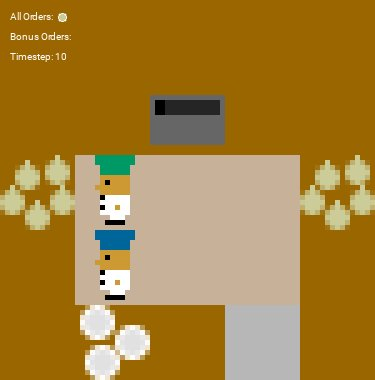

'temp/frame_9.jpg'

In [75]:
hud_data = StateVisualizer.default_hud_data(observation)
StateVisualizer().display_rendered_state(state=observation, grid=GRID, hud_data=hud_data, img_path=img_path, ipython_display=True, window_display=False)

In [85]:
observation_array[...,1].transpose()

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])